# Tools

In [1]:
import os, sys

import numpy as np, tqdm
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

import waveprop, ngi, imp
imp.reload(waveprop)

<module 'waveprop' from '/SNS/users/y9z/Documents/GitHub/research_stuff/jupyter_notebooks/nGI/waveprop.py'>

In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
ngi.nSLD_Si*43.28e-6*7.5e-10/np.pi

2.1397495056031643

In [4]:
ngi.nSLD_Si*25e-6*3.8e-10/np.pi

0.6262359920896506

In [5]:
ngi.nSLD_Si*35e-6*7.6e-10/np.pi

1.7534607778510218

# One wavelength

In [7]:
wavelength = 2.5e-10
d01 = 319.225e-2
d12 = 319.225e-2

g0_dc = 0.58
# g0_dc = 0.7
g0_period = 56.5e-6
g0_slit_width = (1-g0_dc)*g0_period
g0_thickness = 18e-6

# pi shift
g1_period = 56.5e-6
g1_thickness = 60.71e-6

# # pi/2 shift
# g1_period = 28.28e-6
# g1_thickness = 30.35e-6

g2_dc = 0.55
g2_period = 56.5e-6
g2_slit_width = (1-g2_dc)*g2_period
g2_thickness= 18e-6

np_g1 = 2**9 # number of points for the grating 1 period
npoints = 2**13 # total number of points to simulate transversally

In [8]:
b4_gr1, gr1_binary, gr1, after_gr1, b4_gr2 = ngi.nGI_spherical(
    wavelength = wavelength,
    d01= d01, d12 = d12,
    g1_thickness = g1_thickness,
    g1_period = g1_period, np_g1 = np_g1,
    npoints = npoints
)

In [9]:
x, y0, y_projected_G0, y_G2, y0_X_G0, y0_X_G0_X_G2, V = ngi.calc_visibitilty(
    wavelength, 
    g0_slit_width=g0_slit_width, g0_period=g0_period, g0_thickness = g0_thickness,
    g1_thickness = g1_thickness, g1_period = g1_period, np_g1 = np_g1,
    g2_period=g2_period, g2_slit_width=g2_slit_width, g2_thickness = g2_thickness,
    d01= d01, d12 = d12,
    npoints=npoints)
print(V)

0.5757182176364525


/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


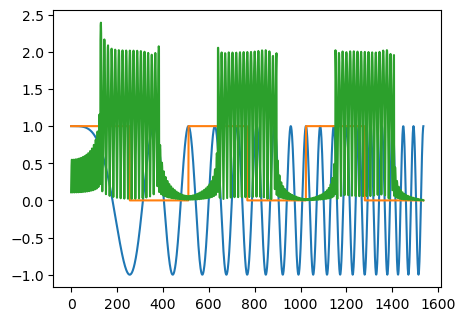

In [10]:
plt.figure(figsize=(5,3.6))
sl = slice(npoints//2, npoints//2+np_g1*3)
plt.plot(b4_gr1[sl])
plt.plot(gr1_binary[sl])
plt.plot(np.abs(b4_gr2)[sl])

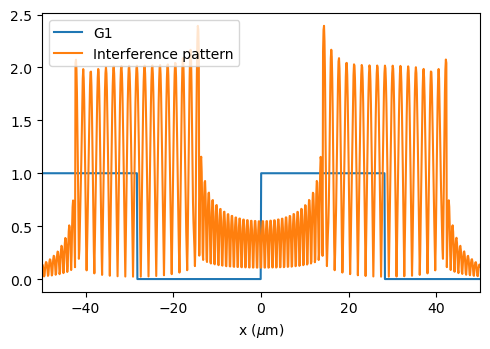

In [11]:
plt.figure(figsize=(5,3.6))
xp = x*1e6
plt.plot(xp, gr1_binary, label='G1')
plt.plot(xp, np.abs(b4_gr2), label='Interference pattern')
plt.legend(loc='upper left')
plt.xlim(-50, 50)
plt.xlabel('x ($\mu$m)')
plt.tight_layout()

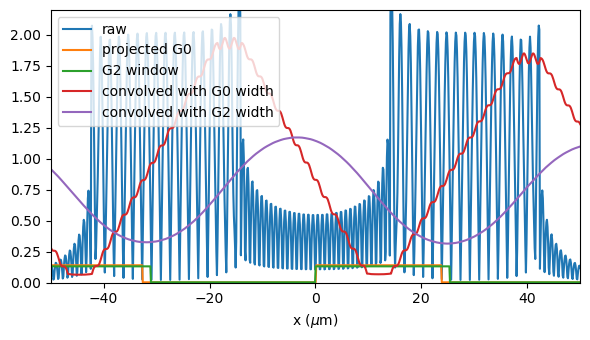

In [12]:
plt.figure(figsize=(6,3.5))
xp = x*1e6
plt.plot(xp, np.abs(y0), label='raw')
plt.plot(xp, y_projected_G0*500, label='projected G0')
# plt.plot(xp, gr0[sl], label='G1')
plt.plot(xp, y_G2*500, label='G2 window')
plt.plot(xp, y0_X_G0, label='convolved with G0 width')
plt.plot(xp, y0_X_G0_X_G2, label='convolved with G2 width')
plt.xlim(-50, 50)
plt.ylim(0, 2.2)
plt.xlabel('x ($\mu$m)')
plt.legend(loc='upper left')
plt.tight_layout()

# Scan wavelength

In [13]:
%%time
Vs = []
wls = np.arange(.5, 12, .1)
for wl in wls:
    x, y0, y_projected_G0, y_G2, y0_X_G0, y0_X_G0_X_G2, V = ngi.calc_visibitilty(
        wl*1e-10, 
        g0_slit_width=g0_slit_width, g0_period=g0_period, g0_thickness = g0_thickness,
        g1_thickness = g1_thickness, g1_period = g1_period, np_g1 = np_g1,
        g2_period=g2_period, g2_slit_width=g2_slit_width, g2_thickness = g2_thickness,
        d01= d01, d12 = d12,
        npoints=npoints)
    Vs.append(V)

CPU times: user 2.62 s, sys: 39.6 ms, total: 2.65 s
Wall time: 2.65 s


/tmp/ipykernel_89937/2170655037.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='r', linestyle='--')


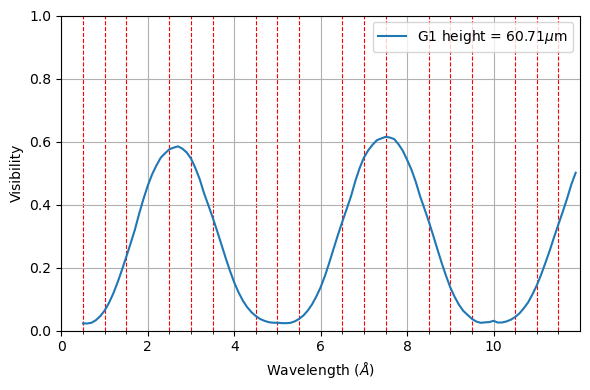

In [14]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(wls, Vs, label = f'G1 height = {g1_thickness*1e6}$\mu$m')
plt.ylim(0,1)
plt.xlim(0.5, 12)
plt.ylabel('Visibility')
plt.xlabel(r'Wavelength ($\AA$)')
plt.legend()
major_ticks = np.arange(0, 12, 2)
minor_ticks = np.arange(0, 12, 0.5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid()
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.tight_layout()

In [15]:
path_to_beam_shape = 'beam_flux_cg1d.txt'
df = pd.read_csv(path_to_beam_shape, sep='\t', skiprows=0)
df.columns = ['wavelength_A', 'flux']
total_flux = np.sum(df['flux'])
df['flux_per'] = df['flux']/total_flux
df_crop = df[df['wavelength_A']<=11.9]
y_function = interp1d(x=wls, y=Vs, kind='cubic')

# add interpolated transmission value to beam shape df
df_crop['visibility'] = y_function(df_crop['wavelength_A'])
# calculated transmitted flux
df_crop['weighted_vis'] = df_crop['visibility'] * df_crop['flux_per']
vis_white = np.sum(df_crop['weighted_vis'])
vis_white

/tmp/ipykernel_89937/3506282604.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crop['visibility'] = y_function(df_crop['wavelength_A'])
/tmp/ipykernel_89937/3506282604.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crop['weighted_vis'] = df_crop['visibility'] * df_crop['flux_per']


0.35107090271805325

# Scan wavelength and G1 thickness

In [14]:
import tqdm

In [ ]:
%%time
Vmat = []
wls = np.arange(.5, 12, .1)
g1ts = np.arange(5, 150, 2.)
for wl in tqdm.tqdm(wls):
    _vs = []
    for g1t in g1ts:
        x, y0, y_projected_G0, y_G2, y0_X_G0, y0_X_G0_X_G2, V  = ngi.calc_visibitilty(
            wl*1e-10, 
            g0_slit_width=g0_slit_width, g0_period=g0_period, g0_thickness = g0_thickness,
            g1_thickness = g1t*1e-6, g1_period = g1_period, np_g1 = np_g1,
            g2_period=g2_period, g2_slit_width=g2_slit_width, g2_thickness = g2_thickness,
            d01= d01, d12 = d12,
            npoints=npoints,
        )
        _vs.append(V)
    Vmat.append(_vs)

 92%|█████████████████████████████████████▊   | 106/115 [03:01<00:15,  1.72s/it]

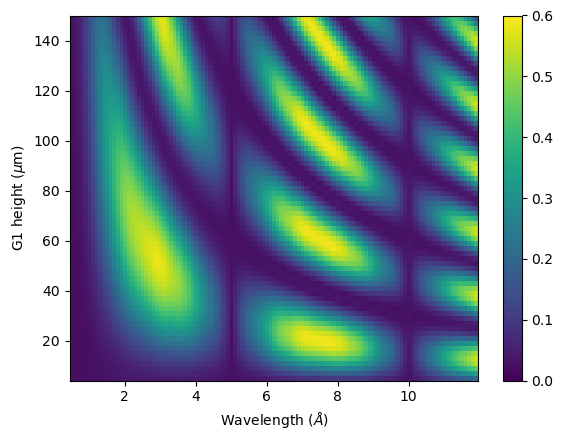

In [16]:
Vmat = np.array(Vmat)
plt.figure(figsize=(6,4.5))
wlg, g1tg = np.meshgrid(wls, g1ts)
plt.pcolormesh(wlg, g1tg, Vmat.T)
plt.colorbar()
plt.clim(0, 0.6)
plt.ylabel('G1 height ($\mu$m)')
plt.xlabel('Wavelength ($\AA$)')
plt.tight_layout()